Basic scikits-leaarn toolchain msetup

In [21]:
from multiprocessing import cpu_count

import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier as Classifier
from sklearn.cross_validation import train_test_split

In [22]:
RANDOM_SEED = 44

In [44]:
cols = features.columns

In [23]:
signal = pd.DataFrame.from_csv('../ML_Events/signal/out_sig.txt', index_col= 0, sep=r'\t')
background = pd.DataFrame.from_csv('../ML_Events/background/out_bk.txt', index_col= 0, sep=r'\t')
signal.columns = background.columns = [s.strip() for s in signal.columns]

emptycols = [c for c in signal.columns if c.startswith("Empty")]
signal.drop(emptycols, axis=1, inplace=True)
background.drop(emptycols, axis=1, inplace=True)

#signal = signal[signal[' Weight'] > 0.005]
#background = background[background[' Weight'] > 0.005]

data = pd.concat([signal, background])
features, weights = data.iloc[:, :-1], data.iloc[:,-1]
weights = np.abs(weights).as_matrix()
labels = np.r_[np.ones(len(signal)), np.zeros(len(background))]

#We split between testing and training by further starifying on weights, by ignoring the smaller ones for each
#category (for the purposes of splitting, we assign them to a third category '2' that tunrns out to be split evenly as well).
weighted_cats = labels.copy()
label_mask = labels.astype(bool)
small_signal = (weights < weights[label_mask].mean()) & label_mask
weighted_cats[small_signal] = 2

small_background = (weights < weights[~label_mask].mean()) & ~label_mask
weighted_cats[small_background] = 2


X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(features, labels, weights,
                                                                     random_state = RANDOM_SEED, 
                                                                     test_size=0.5, stratify=weighted_cats)



#X_train, y_train, w_train = features, labels, weights

/home/zah/anaconda3/lib/python3.5/site-packages/pandas/core/frame.py:1177: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators; you can avoid this warning by specifying engine='python'.
  infer_datetime_format=infer_datetime_format)


In [24]:
len(X_train)

578

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

In [26]:
!nemo .

(array([   2.,    1.,    4.,   20.,   45.,   82.,  164.,  280.,  192.,  367.]),
 array([-17.10343741, -15.25380393, -13.40417046, -11.55453698,
         -9.70490351,  -7.85527003,  -6.00563655,  -4.15600308,
         -2.3063696 ,  -0.45673613,   1.39289735]),
 <a list of 10 Patch objects>)

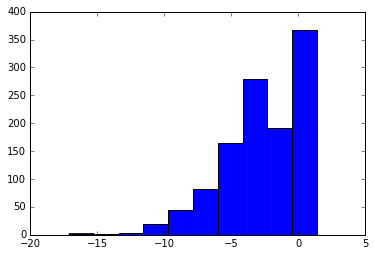

In [27]:
plt.hist(np.log10(weights))

In [28]:
len(data)

1157

In [29]:
sum(w_test)

534.2627116479224

In [30]:
sum(w_train)

409.44000376948844

In [31]:
sum(y_train*w_train)

389.10316437864867

In [32]:
sum(y_test*w_test)

514.17053232031867

In [33]:
clf = Classifier(n_estimators=10000, max_depth=4, min_weight_fraction_leaf=0.05 , n_jobs=cpu_count() ,random_state=RANDOM_SEED)

In [34]:
clf.fit(X_train,y_train, sample_weight=w_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.05, n_estimators=10000, n_jobs=4,
            oob_score=False, random_state=44, verbose=0, warm_start=False)

In [35]:
clf.score(X_test, y_test, sample_weight=w_test)

0.96239269765686986

In [36]:
clf.score(X_train, y_train, sample_weight=w_train)m

SyntaxError: invalid syntax (<ipython-input-36-85325a2791f5>, line 1)

In [ ]:
est_scores = [est.score(X_test, y_test, sample_weight=w_test) for est in clf.estimators_]

In [ ]:
from smpdflib.initialization import init_style
init_style()

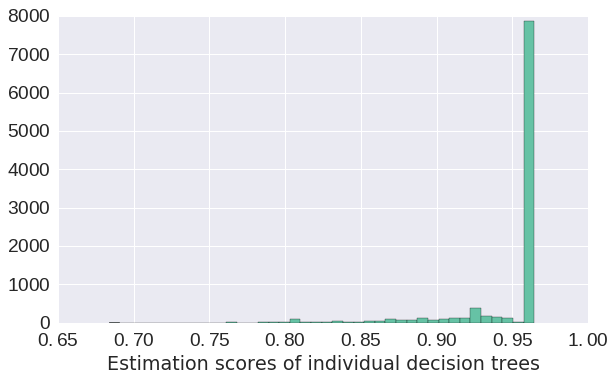

In [138]:
plt.hist(est_scores, bins=40)
plt.xlabel("Estimation scores of individual decision trees")
plt.savefig("ind_dt_dist.pdf")

In [139]:
sum(w_test)

534.2627116479224

In [140]:
sum(w_train)

409.44000376948844

In [141]:
importances = clf.feature_importances_

In [142]:
import matplotlib.pyplot as plt

In [143]:
importances = pd.Series(importances, index=features.columns)

In [144]:
sv = importances.sort_values()
c,d = sv.index[-2:]

In [18]:
best_features = sv.index[-4:]

NameError: name 'sv' is not defined

In [19]:
sv

NameError: name 'sv' is not defined

In [20]:
pairs = list(itertools.combinations(best_features,2))

NameError: name 'best_features' is not defined

In [148]:
best_features

Index(['| Delta eta l1,l2 |', '| Delta eta j1,j2 |', 'Centrality', 'm j1, j2'], dtype='object')

In [17]:
import itertools
pairs = (itertools.combinations(best_features,2))
fig, axes = plt.subplots(2,3, figsize=(20, 10))
axiter = (ax  for l in axes for ax in l)
for (c,d), ax in zip(pairs, axiter):
    print(c)
    ax.scatter(c,d, data=signal, label="Signal")
    ax.scatter(c,d, data=background, color='orange', label="Background")
    ax.set_xlabel(c)
    ax.set_ylabel(d)
    ax.legend(loc='best')
plt.tight_layout()
plt.savefig("features.pdf")
    

NameError: name 'best_features' is not defined

In [16]:
proba_test = clf.predict_proba(X_test)

In [153]:
import seaborn

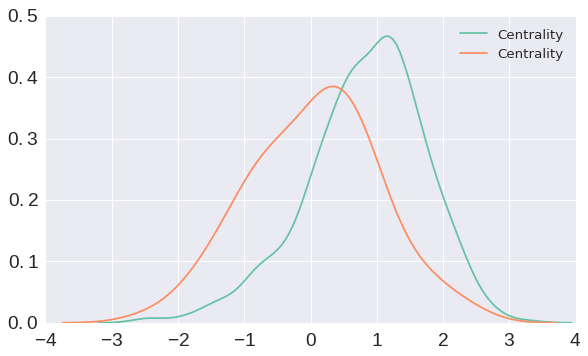

In [154]:
seaborn.kdeplot(signal.Centrality)
seaborn.kdeplot(background.Centrality)

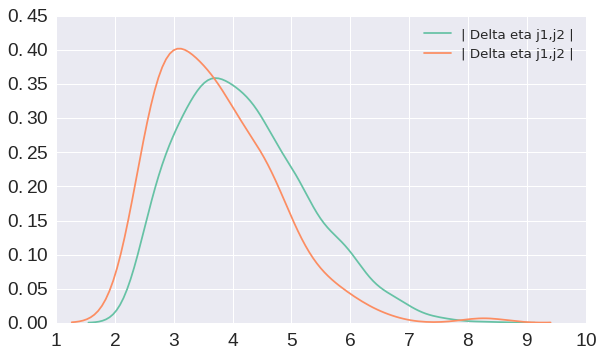

In [155]:
f1 = '| Delta eta j1,j2 |'
seaborn.kdeplot(signal['| Delta eta j1,j2 |'])
seaborn.kdeplot(background['| Delta eta j1,j2 |'])

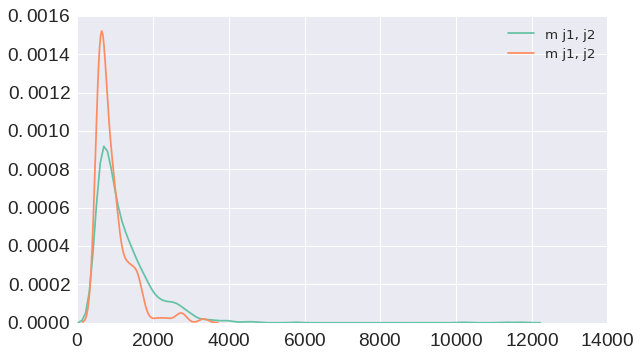

In [159]:
f2 = 'm j1, j2'
seaborn.kdeplot(signal[f2])
seaborn.kdeplot(background[f2])

In [81]:
from sklearn.lda import LDA

In [90]:
lda = LDA().fit(X_train[[f1,f2]], y_train)

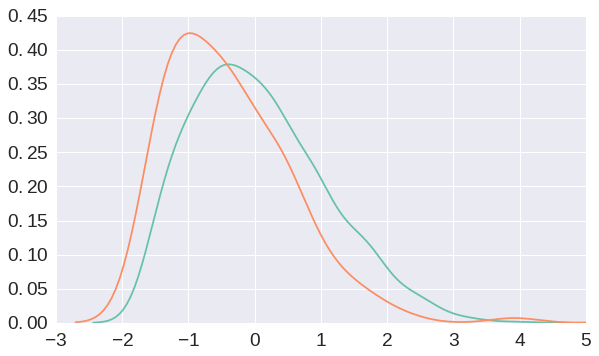

In [109]:
nf_s = lda.transform(signal[[f1,f2]]).ravel()
nf_b = lda.transform(background[[f1,f2]]).ravel()
seaborn.kdeplot(nf_s)
seaborn.kdeplot(nf_b)

In [ ]:
from sklearn.k

In [106]:
nf.ravel()

array([ 1.02466255,  1.80099754,  0.50137518, ..., -1.47597601,
       -1.11763983, -1.15642793])

In [75]:
predicted_test = clf.predict_proba(X_test)[:,1]

In [76]:
from sklearn.metrics import roc_auc_score, roc_curve

In [77]:
roc_curve??

In [78]:

fpr, tpr, thresholds = roc_curve(y_test, predicted_test, sample_weight=w_test)

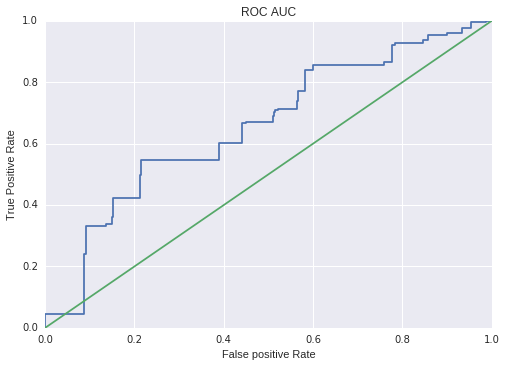

In [81]:
plt.plot(fpr, tpr)
plt.plot(fpr, fpr)
plt.title("ROC AUC")
plt.xlabel("False positive Rate")
plt.ylabel("True Positive Rate")

In [80]:
clf.predict(signal[])

SyntaxError: invalid syntax (<ipython-input-80-c505c89abd3f>, line 1)

In [ ]:
roc_auc_score?

In [116]:
clf.classes_

array([ 0.,  1.])

In [117]:
probs = np.linspace(0,1,30)

In [161]:
t = clf.estimators_[0].tree_

In [166]:
clf.estimators_[0]

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.05,
            presort=False, random_state=1438136084, splitter='best')

In [167]:
from sklearn.tree import export_graphviz

In [169]:
export_graphviz??

In [170]:
export_graphviz(t, feature_names=features.columns)

In [61]:
clf.classes_

array([ 0.,  1.])

In [64]:
clf.predict_proba(signal[cols])[:,1];

In [65]:
sp = clf.predict_proba(signal[cols])[:,1]
bp = clf.predict_proba(background[cols])[:,1]

In [66]:
import seaborn

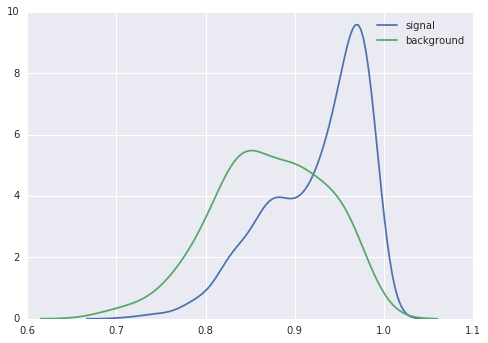

In [67]:
seaborn.kdeplot(sp, label="signal")
seaborn.kdeplot(bp, label="background")

In [69]:
seaborn.kdeplot??